### Name: Sachid Deshmukh
### Date: 07-13-2019
### Data 612 Final Project
### Reference - https://www.kaggle.com/gspmoreira/recommender-systems-in-python-101


### In this project we will implement four different recommender systems and compare their performance
- **Popular Item Model** - Baseline model which recommends most popular items based on global average
- **Collaborative Filtering** - This method makes automatic predictions (filtering) about the interests of a user by collecting preferences or taste information from many users (collaborating). The underlying assumption of the collaborative filtering approach is that if a person A has the same opinion as a person B on a set of items, A is more likely to have B's opinion for a given item than that of a randomly chosen person.
- **Content Based Filtering** - This method uses only information about the description and attributes of the items users has previously consumed to model user's preferences. In other words, these algorithms try to recommend items that are similar to those that a user liked in the past (or is examining in the present). In particular, various candidate items are compared with items previously rated by the user and the best-matching items are recommended.
- **Hybrid Method** - Ensemble of Collaborative filtering and Content Based filtering

### Load necessary libraries

In [55]:
import numpy as np
import scipy
import pandas as pd
import math
import random
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse.linalg import svds
import matplotlib.pyplot as plt
from nltk.corpus import stopwords

### In this project we are using two datasets
 - **articles.csv** - This file contains all the available articles for users consumption
 - **users_interactions.csv** - This file contains users interaction on the article. Typical user interactions are View, Click, Like and provide feedback on the articles

In [56]:
articles_df = pd.read_csv('D:/MSDS/MSDSQ3Data612/FinalProject/shared_articles.csv/shared_articles.csv')
articles_df = articles_df[articles_df['eventType'] == 'CONTENT SHARED']
articles_df.head(5)


,timestamp,eventType,contentId,authorPersonId,authorSessionId,authorUserAgent,authorRegion,authorCountry,contentType,url,title,text,lang
1,1459193988,CONTENT SHARED,-4110354420726924665,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://www.nytimes.com/2016/03/28/business/dea...,"Ethereum, a Virtual Currency, Enables Transact...",All of this work is still very early. The firs...,en
2,1459194146,CONTENT SHARED,-7292285110016212249,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://cointelegraph.com/news/bitcoin-future-w...,Bitcoin Future: When GBPcoin of Branson Wins O...,The alarm clock wakes me at 8:00 with stream o...,en
3,1459194474,CONTENT SHARED,-6151852268067518688,3891637997717104548,-1457532940883382585,NaN,NaN,NaN,HTML,https://cloudplatform.googleblog.com/2016/03/G...,Google Data Center 360° Tour,We're excited to share the Google Data Center ...,en
4,1459194497,CONTENT SHARED,2448026894306402386,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,https://bitcoinmagazine.com/articles/ibm-wants...,"IBM Wants to ""Evolve the Internet"" With Blockc...",The Aite Group projects the blockchain market ...,en
5,1459194522,CONTENT SHARED,-2826566343807132236,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://www.coindesk.com/ieee-blockchain-oxford...,IEEE to Talk Blockchain at Cloud Computing Oxf...,One of the largest and oldest organizations fo...,en


In [57]:
interactions_df = pd.read_csv('D:/MSDS/MSDSQ3Data612/FinalProject/users_interactions.csv/users_interactions.csv')
interactions_df.head(10)

,timestamp,eventType,contentId,personId,sessionId,userAgent,userRegion,userCountry
0,1465413032,VIEW,-3499919498720038879,-8845298781299428018,1264196770339959068,NaN,NaN,NaN
1,1465412560,VIEW,8890720798209849691,-1032019229384696495,3621737643587579081,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_2...,NY,US
2,1465416190,VIEW,310515487419366995,-1130272294246983140,2631864456530402479,NaN,NaN,NaN
3,1465413895,FOLLOW,310515487419366995,344280948527967603,-3167637573980064150,NaN,NaN,NaN
4,1465412290,VIEW,-7820640624231356730,-445337111692715325,5611481178424124714,NaN,NaN,NaN
5,1465413742,VIEW,310515487419366995,-8763398617720485024,1395789369402380392,Mozilla/5.0 (Windows NT 10.0; WOW64) AppleWebK...,MG,BR
6,1465415950,VIEW,-8864073373672512525,3609194402293569455,1143207167886864524,NaN,NaN,NaN
7,1465415066,VIEW,-1492913151930215984,4254153380739593270,8743229464706506141,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...,SP,BR
8,1465413762,VIEW,310515487419366995,344280948527967603,-3167637573980064150,NaN,NaN,NaN
9,1465413771,VIEW,3064370296170038610,3609194402293569455,1143207167886864524,NaN,NaN,NaN


### Data Wrangling
#### As there are different interactions types, we associate them with a weight or strength, assuming that, for example, a comment in an article indicates a higher interest of the user on the item than a like, or than a simple view.

In [58]:
event_type_strength = {
   'VIEW': 1.0,
   'LIKE': 2.0, 
   'BOOKMARK': 2.5, 
   'FOLLOW': 3.0,
   'COMMENT CREATED': 4.0,  
}

interactions_df['eventStrength'] = interactions_df['eventType'].apply(lambda x: event_type_strength[x])

#### Recommender systems have a problem known as user cold-start, in which is hard do provide personalized recommendations for users with none or a very few number of consumed items, due to the lack of information to model their preferences. For this reason, we are keeping in the dataset only users with at leas 5 interactions.

In [59]:
users_interactions_count_df =interactions_df.groupby(['personId', 'contentId']).size().reset_index().groupby('personId').size().reset_index()
users_interactions_count_df.columns = ['personId', 'interCount']
print('# users: %d' % len(users_interactions_count_df))
users_with_enough_interactions_df = users_interactions_count_df[users_interactions_count_df.interCount>= 5].reset_index()[['personId']]

print('# users with at least 5 interactions: %d' % len(users_with_enough_interactions_df))


# users: 1895
# users with at least 5 interactions: 1140


In [60]:
print('# of interactions: %d' % len(interactions_df))
interactions_from_selected_users_df = interactions_df.merge(users_with_enough_interactions_df, 
               how = 'right',
               left_on = 'personId',
               right_on = 'personId')
print('# of interactions from users with at least 5 interactions: %d' % len(interactions_from_selected_users_df))


# of interactions: 72312
# of interactions from users with at least 5 interactions: 69868


#### In Deskdrop, users are allowed to view an article many times, and interact with them in different ways (eg. like or comment). Thus, to model the user interest on a given article, we aggregate all the interactions the user has performed in an item by a weighted sum of interaction type strength and apply a log transformation to smooth the distribution.

In [61]:
def smooth_user_preference(x):
    return math.log(1+x, 2)
    
interactions_full_df = interactions_from_selected_users_df \
                    .groupby(['personId', 'contentId'])['eventStrength'].sum() \
                    .apply(smooth_user_preference).reset_index()
print('# of unique user/item interactions: %d' % len(interactions_full_df))
interactions_full_df.head(10)

# of unique user/item interactions: 39106


,personId,contentId,eventStrength
0,-9223121837663643404,-8949113594875411859,1.000000
1,-9223121837663643404,-8377626164558006982,1.000000
2,-9223121837663643404,-8208801367848627943,1.000000
3,-9223121837663643404,-8187220755213888616,1.000000
4,-9223121837663643404,-7423191370472335463,3.169925
5,-9223121837663643404,-7331393944609614247,1.000000
6,-9223121837663643404,-6872546942144599345,1.000000
7,-9223121837663643404,-6728844082024523434,1.000000
8,-9223121837663643404,-6590819806697898649,1.000000
9,-9223121837663643404,-6558712014192834002,1.584963


#### Split data in train and test set

In [8]:
interactions_train_df, interactions_test_df = train_test_split(interactions_full_df,
                                   stratify=interactions_full_df['personId'], 
                                   test_size=0.20,
                                   random_state=42)

print('# interactions on Train set: %d' % len(interactions_train_df))
print('# interactions on Test set: %d' % len(interactions_test_df))

# interactions on Train set: 31284
# interactions on Test set: 7822


In [9]:
#Indexing by personId to speed up the searches during evaluation
interactions_full_indexed_df = interactions_full_df.set_index('personId')
interactions_train_indexed_df = interactions_train_df.set_index('personId')
interactions_test_indexed_df = interactions_test_df.set_index('personId')

In [10]:
def get_items_interacted(person_id, interactions_df):
    # Get the user's data and merge in the movie information.
    interacted_items = interactions_df.loc[person_id]['contentId']
    return set(interacted_items if type(interacted_items) == pd.Series else [interacted_items])


#### Utility class to evaluate model performance 

In [11]:
#Top-N accuracy metrics consts
EVAL_RANDOM_SAMPLE_NON_INTERACTED_ITEMS = 100

class ModelEvaluator:


    def get_not_interacted_items_sample(self, person_id, sample_size, seed=42):
        interacted_items = get_items_interacted(person_id, interactions_full_indexed_df)
        all_items = set(articles_df['contentId'])
        non_interacted_items = all_items - interacted_items

        random.seed(seed)
        non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
        return set(non_interacted_items_sample)

    def _verify_hit_top_n(self, item_id, recommended_items, topn):        
            try:
                index = next(i for i, c in enumerate(recommended_items) if c == item_id)
            except:
                index = -1
            hit = int(index in range(0, topn))
            return hit, index

    def evaluate_model_for_user(self, model, person_id):
        #Getting the items in test set
        interacted_values_testset = interactions_test_indexed_df.loc[person_id]
        if type(interacted_values_testset['contentId']) == pd.Series:
            person_interacted_items_testset = set(interacted_values_testset['contentId'])
        else:
            person_interacted_items_testset = set([int(interacted_values_testset['contentId'])])  
        interacted_items_count_testset = len(person_interacted_items_testset) 

        #Getting a ranked recommendation list from a model for a given user
        person_recs_df = model.recommend_items(person_id, items_to_ignore=get_items_interacted(person_id, interactions_train_indexed_df), topn=10000000000)

        hits_at_5_count = 0
        hits_at_10_count = 0
        #For each item the user has interacted in test set
        for item_id in person_interacted_items_testset:
           #Getting a random sample (100) items the user has not interacted 
           #(to represent items that are assumed to be no relevant to the user)
            non_interacted_items_sample = self.get_not_interacted_items_sample(person_id, sample_size=EVAL_RANDOM_SAMPLE_NON_INTERACTED_ITEMS,seed=item_id%(2**32))
            #Combining the current interacted item with the 100 random items
            items_to_filter_recs = non_interacted_items_sample.union(set([item_id]))
            
            #Filtering only recommendations that are either the interacted item or from a random sample of 100 non-interacted items
            valid_recs_df = person_recs_df[person_recs_df['contentId'].isin(items_to_filter_recs)]                    
            valid_recs = valid_recs_df['contentId'].values
            #Verifying if the current interacted item is among the Top-N recommended items
            hit_at_5, index_at_5 = self._verify_hit_top_n(item_id, valid_recs, 5)
            hits_at_5_count += hit_at_5
            hit_at_10, index_at_10 = self._verify_hit_top_n(item_id, valid_recs, 10)
            hits_at_10_count += hit_at_10

        #Recall is the rate of the interacted items that are ranked among the Top-N recommended items, 
        #when mixed with a set of non-relevant items
        recall_at_5 = hits_at_5_count / float(interacted_items_count_testset)
        recall_at_10 = hits_at_10_count / float(interacted_items_count_testset)
        person_metrics = {'hits@5_count':hits_at_5_count, 
                          'hits@10_count':hits_at_10_count, 
                          'interacted_count': interacted_items_count_testset,
                          'recall@5': recall_at_5,
                          'recall@10': recall_at_10}
        return person_metrics

    def evaluate_model(self, model):
        #print('Running evaluation for users')
        people_metrics = []
        for idx, person_id in enumerate(list(interactions_test_indexed_df.index.unique().values)):
            #if idx % 100 == 0 and idx > 0:
            #    print('%d users processed' % idx)
            person_metrics = self.evaluate_model_for_user(model, person_id)  
            person_metrics['_person_id'] = person_id
            people_metrics.append(person_metrics)
        print('%d users processed' % idx)

        detailed_results_df = pd.DataFrame(people_metrics) \
                            .sort_values('interacted_count', ascending=False)
        
        global_recall_at_5 = detailed_results_df['hits@5_count'].sum() / float(detailed_results_df['interacted_count'].sum())
        global_recall_at_10 = detailed_results_df['hits@10_count'].sum() / float(detailed_results_df['interacted_count'].sum())
        
        global_metrics = {'modelName': model.get_model_name(),
                          'recall@5': global_recall_at_5,
                          'recall@10': global_recall_at_10}    
        return global_metrics, detailed_results_df
    
model_evaluator = ModelEvaluator()

### Popularity Model
#### A common (and usually hard-to-beat) baseline approach is the Popularity model. This model is not actually personalized - it simply recommends to a user the most popular items that the user has not previously consumed. As the popularity accounts for the "wisdom of the crowds", it usually provides good recommendations, generally interesting for most people. 

In [62]:
item_popularity_df = interactions_full_df.groupby('contentId')['eventStrength'].sum().sort_values(ascending=False).reset_index()
item_popularity_df.head(10)

,contentId,eventStrength
0,-4029704725707465084,307.733799
1,-6783772548752091658,233.762157
2,-133139342397538859,228.024567
3,-8208801367848627943,197.107608
4,-6843047699859121724,193.825208
5,8224860111193157980,189.044680
6,-2358756719610361882,183.110951
7,2581138407738454418,180.282876
8,7507067965574797372,179.094002
9,1469580151036142903,170.548969


In [63]:
class PopularityRecommender:
    
    MODEL_NAME = 'Popularity'
    
    def __init__(self, popularity_df, items_df=None):
        self.popularity_df = popularity_df
        self.items_df = items_df
        
    def get_model_name(self):
        return self.MODEL_NAME
        
    def recommend_items(self, user_id, items_to_ignore=[], topn=10, verbose=False):
        # Recommend the more popular items that the user hasn't seen yet.
        recommendations_df = self.popularity_df[~self.popularity_df['contentId'].isin(items_to_ignore)].sort_values('eventStrength', ascending = False).head(topn)

        return recommendations_df
    
popularity_model = PopularityRecommender(item_popularity_df, articles_df)

In [64]:
print('Evaluating Popularity recommendation model...')
pop_global_metrics, pop_detailed_results_df = model_evaluator.evaluate_model(popularity_model)

print('\nGlobal metrics:\n%s' % pop_global_metrics)

Evaluating Popularity recommendation model...
1139 users processed

Global metrics:
{'modelName': 'Popularity', 'recall@5': 0.2418818716440808, 'recall@10': 0.3725389925850166}


#### Here we perform the evaluation of the Popularity model, according to the method described above.It achieved the Recall@5 of 0.2417, which means that about 24% of interacted items in test set were ranked by Popularity model among the top-5 items (from lists with 100 random items). And Recall@10 was even higher (37%), as expected.

### Content-Based Filtering model
#### Content-based filtering approaches leverage description or attributes from items the user has interacted to recommend similar items. It depends only on the user previous choices, making this method robust to avoid the cold-start problem. For textual items, like articles, news and books, it is simple to use the raw text to build item profiles and user profiles. Here we are using a very popular technique in information retrieval (search engines) named TF-IDF. This technique converts unstructured text into a vector structure, where each word is represented by a position in the vector, and the value measures how relevant a given word is for an article. As all items will be represented in the same Vector Space Model, it is to compute similarity between articles.

### Build Item Profile

In [65]:

stopwords_list = stopwords.words('english') + stopwords.words('portuguese')
vectorizer = TfidfVectorizer(analyzer='word',
                     ngram_range=(1, 2),
                     min_df=0.003,
                     max_df=0.5,
                     max_features=5000,
                     stop_words=stopwords_list)

item_ids = articles_df['contentId'].tolist()
tfidf_matrix = vectorizer.fit_transform(articles_df['title'] + "" + articles_df['text'])
tfidf_feature_names = vectorizer.get_feature_names()
tfidf_matrix

<3047x5000 sparse matrix of type '<class 'numpy.float64'>'
	with 638928 stored elements in Compressed Sparse Row format>

In [66]:
def get_item_profile(item_id):
    idx = item_ids.index(item_id)
    item_profile = tfidf_matrix[idx:idx+1]
    return item_profile

def get_item_profiles(ids):
    item_profiles_list = [get_item_profile(x) for x in ids]
    item_profiles = scipy.sparse.vstack(item_profiles_list)
    return item_profiles

def build_users_profile(person_id, interactions_indexed_df):
    interactions_person_df = interactions_indexed_df.loc[person_id]
    user_item_profiles = get_item_profiles(interactions_person_df['contentId'])
    
    user_item_strengths = np.array(interactions_person_df['eventStrength']).reshape(-1,1)
    #Weighted average of item profiles by the interactions strength
    user_item_strengths_weighted_avg = np.sum(user_item_profiles.multiply(user_item_strengths), axis=0) / np.sum(user_item_strengths)
    #user_profile_norm = sklearn.preprocessing.normalize(user_item_strengths_weighted_avg)
    user_profile_norm = user_item_strengths_weighted_avg
    return user_profile_norm

def build_users_profiles(): 
    interactions_indexed_df = interactions_full_df[interactions_full_df['contentId'] \
                                                   .isin(articles_df['contentId'])].set_index('personId')
    user_profiles = {}
    for person_id in interactions_indexed_df.index.unique():
        user_profiles[person_id] = build_users_profile(person_id, interactions_indexed_df)
    return user_profiles

### Build User profile

In [25]:
user_profiles = build_users_profiles()
len(user_profiles)

1140

In [67]:
class ContentBasedRecommender:
    
    MODEL_NAME = 'Content-Based'
    
    def __init__(self, items_df=None):
        self.item_ids = item_ids
        self.items_df = items_df
        
    def get_model_name(self):
        return self.MODEL_NAME
        
    def _get_similar_items_to_user_profile(self, person_id, topn=1000):
        #Computes the cosine similarity between the user profile and all item profiles
        cosine_similarities = cosine_similarity(user_profiles[person_id], tfidf_matrix)
        #Gets the top similar items
        similar_indices = cosine_similarities.argsort().flatten()[-topn:]
        #Sort the similar items by similarity
        similar_items = sorted([(item_ids[i], cosine_similarities[0,i]) for i in similar_indices], key=lambda x: -x[1])
        return similar_items
        
    def recommend_items(self, user_id, items_to_ignore=[], topn=10, verbose=False):
        similar_items = self._get_similar_items_to_user_profile(user_id)
        #Ignores items the user has already interacted
        similar_items_filtered = list(filter(lambda x: x[0] not in items_to_ignore, similar_items))
        
        recommendations_df = pd.DataFrame(similar_items_filtered, columns=['contentId', 'recStrength']) \
                                    .head(topn)
        return recommendations_df
    
content_based_recommender_model = ContentBasedRecommender(articles_df)

In [68]:
print('Evaluating Content-Based Filtering model...')
cb_global_metrics, cb_detailed_results_df = model_evaluator.evaluate_model(content_based_recommender_model)
print('\nGlobal metrics:\n%s' % cb_global_metrics)


Evaluating Content-Based Filtering model...
1139 users processed

Global metrics:
{'modelName': 'Content-Based', 'recall@5': 0.41459984658655075, 'recall@10': 0.5241626182562005}


#### With personalized recommendations of content-based filtering model, we have a jump on Recall@5 to about 0.4145, which means that about 41% of interacted items in test set were ranked by this model among the top-5 items (from lists with 100 random items). And Recall@10 was 0.5241 (52%). Definitelly not bad!

### Collaborative Filtering model

#### We will use SVD to create latent factors and build collaborative filtering model to provide personalized recommendations


### Create item to item matrix

In [69]:
#Creating a sparse pivot table with users in rows and items in columns
users_items_pivot_matrix_df = interactions_train_df.pivot(index='personId', 
                                                          columns='contentId', 
                                                          values='eventStrength').fillna(0)

users_items_pivot_matrix_df.head(10)

contentId,-9222795471790223670,-9216926795620865886,-9194572880052200111,-9192549002213406534,-9190737901804729417,-9189659052158407108,-9176143510534135851,-9172673334835262304,-9171475473795142532,-9166778629773133902,...,9191014301634017491,9207286802575546269,9208127165664287660,9209629151177723638,9209886322932807692,9213260650272029784,9215261273565326920,9217155070834564627,9220445660318725468,9222265156747237864
personId,,,,,,,,,,,,,,,,,,,,,
-9223121837663643404,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-9212075797126931087,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-9207251133131336884,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-9199575329909162940,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-9196668942822132778,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-9188188261933657343,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-9172914609055320039,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-9156344805277471150,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-9120685872592674274,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [70]:
users_items_pivot_matrix = users_items_pivot_matrix_df.as_matrix()
users_items_pivot_matrix[:10]

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 2., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

### Create latent factors using SVD ( number of latent factors = 15)

In [71]:
#The number of factors to factor the user-item matrix.
NUMBER_OF_FACTORS_MF = 15
#Performs matrix factorization of the original user item matrix
U, sigma, Vt = svds(users_items_pivot_matrix, k = NUMBER_OF_FACTORS_MF)
sigma = np.diag(sigma)


### Calculate personalized recommendations using latent factors

In [72]:
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) 
all_user_predicted_ratings

array([[ 0.01039915,  0.00081872, -0.01725263, ...,  0.00140708,
         0.0110647 ,  0.00226063],
       [-0.00019285, -0.00031318, -0.00264624, ...,  0.00251658,
         0.00017609, -0.00189488],
       [-0.01254721,  0.0065947 , -0.00590676, ...,  0.00698975,
        -0.01015696,  0.01154572],
       ...,
       [-0.02995379,  0.00805715, -0.01846307, ..., -0.01083078,
        -0.00118591,  0.0096798 ],
       [-0.01845505,  0.00467019,  0.01219602, ...,  0.00409507,
         0.00019482, -0.00752562],
       [-0.01506374,  0.00327732,  0.13391269, ..., -0.01191815,
         0.06422074,  0.01303244]])

In [73]:
users_ids = list(users_items_pivot_matrix_df.index)
cf_preds_df = pd.DataFrame(all_user_predicted_ratings, columns = users_items_pivot_matrix_df.columns, index=users_ids).transpose()
cf_preds_df.head(10)

,-9223121837663643404,-9212075797126931087,-9207251133131336884,-9199575329909162940,-9196668942822132778,-9188188261933657343,-9172914609055320039,-9156344805277471150,-9120685872592674274,-9109785559521267180,...,9105269044962898535,9109075639526981934,9135582630122950040,9137372837662939523,9148269800512008413,9165571805999894845,9187866633451383747,9191849144618614467,9199170757466086545,9210530975708218054
contentId,,,,,,,,,,,,,,,,,,,,,
-9222795471790223670,0.010399,-0.000193,-0.012547,0.052958,-0.010035,-0.005412,-0.003918,0.049302,-0.013458,-0.020052,...,-0.005306,-0.089463,-0.000048,0.015023,0.020953,-0.009394,-0.019114,-0.029954,-0.018455,-0.015064
-9216926795620865886,0.000819,-0.000313,0.006595,-0.000649,0.000151,0.000338,0.000197,0.000861,0.002341,0.001765,...,0.000095,0.013915,0.000506,0.001460,0.014863,0.000940,0.002391,0.008057,0.004670,0.003277
-9194572880052200111,-0.017253,-0.002646,-0.005907,-0.003666,0.021300,-0.001278,0.029100,-0.014730,-0.023410,0.004950,...,0.011529,0.046012,0.010485,0.018768,0.150362,0.019052,0.023870,-0.018463,0.012196,0.133913
-9192549002213406534,0.035081,0.000391,-0.029046,-0.007702,0.017615,0.005496,0.013435,0.057563,0.047532,0.004209,...,0.020149,0.260317,0.007923,-0.008079,0.034164,0.011558,0.013793,-0.010138,0.025703,0.095753
-9190737901804729417,0.019939,-0.004799,0.006684,0.006363,-0.001997,0.002356,0.003876,0.004118,-0.027098,0.019793,...,0.003719,0.004478,0.001917,0.000341,-0.034535,-0.001160,0.001307,0.002957,0.005991,-0.015662
-9189659052158407108,0.008661,0.006604,0.001463,-0.002918,0.008551,-0.001637,0.005443,0.002193,0.023148,0.021311,...,0.024496,0.090091,-0.002703,0.001883,0.098925,0.008484,0.014513,0.016385,0.021794,0.068420
-9176143510534135851,0.046426,0.006374,0.013802,0.010265,-0.002538,-0.004453,0.016615,0.023070,0.059582,0.057307,...,0.003667,0.073024,-0.015438,0.001199,-0.005606,-0.000307,0.005250,0.041064,0.030733,0.037113
-9172673334835262304,0.005083,0.000618,0.002845,-0.001103,0.000398,0.000754,0.001346,0.002713,-0.002811,0.003930,...,0.005625,0.019382,0.000544,-0.000992,-0.008110,0.000156,0.003408,0.003614,0.007607,-0.003650
-9171475473795142532,0.024453,-0.000761,0.000963,-0.002817,0.002466,0.001215,0.009339,-0.003530,-0.007137,0.023221,...,0.009667,0.017163,0.000424,0.000060,-0.016698,0.002045,0.007644,0.000955,0.011074,-0.006657


In [74]:
class CFRecommender:
    
    MODEL_NAME = 'Collaborative Filtering'
    
    def __init__(self, cf_predictions_df, items_df=None):
        self.cf_predictions_df = cf_predictions_df
        self.items_df = items_df
        
    def get_model_name(self):
        return self.MODEL_NAME
        
    def recommend_items(self, user_id, items_to_ignore=[], topn=10, verbose=False):
        # Get and sort the user's predictions
        sorted_user_predictions = self.cf_predictions_df[user_id].sort_values(ascending=False) \
                                    .reset_index().rename(columns={user_id: 'recStrength'})

        # Recommend the highest predicted rating movies that the user hasn't seen yet.
        recommendations_df = sorted_user_predictions[~sorted_user_predictions['contentId'].isin(items_to_ignore)] \
                               .sort_values('recStrength', ascending = False) \
                               .head(topn)

        

        return recommendations_df
    
cf_recommender_model = CFRecommender(cf_preds_df, articles_df)

In [75]:
print('Evaluating Collaborative Filtering (SVD Matrix Factorization) model...')
cf_global_metrics, cf_detailed_results_df = model_evaluator.evaluate_model(cf_recommender_model)
print('\nGlobal metrics:\n%s' % cf_global_metrics)


Evaluating Collaborative Filtering (SVD Matrix Factorization) model...
1139 users processed

Global metrics:
{'modelName': 'Collaborative Filtering', 'recall@5': 0.33392994119151115, 'recall@10': 0.46803886474047557}


#### Evaluating the Collaborative Filtering model (SVD matrix factorization), we observe that we got Recall@5 (33%) and Recall@10 (46%) values higher than Popularity model, but lower than Content-Based model. It appears that for this dataset, Content-Based approach is being benefited by the rich item attributes (text) for a better modeling of users preferences.

### Hybrid Recommender
#### What if we combine Collaborative Filtering and Content-Based Filtering approaches? Would that provide us with more accurate recommendations? In fact, hybrid methods have performed better than individual approaches in many studies and have being extensively used by researchers and practioners. Let's build a simple hybridization method, by only multiply the CF score with the Content-Based score, and ranking by resulting score.

In [76]:
class HybridRecommender:
    
    MODEL_NAME = 'Hybrid'
    
    def __init__(self, cb_rec_model, cf_rec_model, items_df):
        self.cb_rec_model = cb_rec_model
        self.cf_rec_model = cf_rec_model
        self.items_df = items_df
        
    def get_model_name(self):
        return self.MODEL_NAME
        
    def recommend_items(self, user_id, items_to_ignore=[], topn=10, verbose=False):
        #Getting the top-1000 Content-based filtering recommendations
        cb_recs_df = self.cb_rec_model.recommend_items(user_id, items_to_ignore=items_to_ignore, verbose=verbose,
                                                           topn=1000).rename(columns={'recStrength': 'recStrengthCB'})
        
        #Getting the top-1000 Collaborative filtering recommendations
        cf_recs_df = self.cf_rec_model.recommend_items(user_id, items_to_ignore=items_to_ignore, verbose=verbose, 
                                                           topn=1000).rename(columns={'recStrength': 'recStrengthCF'})
        
        #Combining the results by contentId
        recs_df = cb_recs_df.merge(cf_recs_df,
                                   how = 'inner', 
                                   left_on = 'contentId', 
                                   right_on = 'contentId')
        
        #Computing a hybrid recommendation score based on CF and CB scores
        recs_df['recStrengthHybrid'] = recs_df['recStrengthCB'] * recs_df['recStrengthCF']
        
        #Sorting recommendations by hybrid score
        recommendations_df = recs_df.sort_values('recStrengthHybrid', ascending=False).head(topn)

        if verbose:
            if self.items_df is None:
                raise Exception('"items_df" is required in verbose mode')

            recommendations_df = recommendations_df.merge(self.items_df, how = 'left', 
                                                          left_on = 'contentId', 
                                                          right_on = 'contentId')[['recStrengthHybrid', 'contentId', 'title', 'url', 'lang']]


        return recommendations_df
    
hybrid_recommender_model = HybridRecommender(content_based_recommender_model, cf_recommender_model, articles_df)

In [77]:
print('Evaluating Hybrid model...')
hybrid_global_metrics, hybrid_detailed_results_df = model_evaluator.evaluate_model(hybrid_recommender_model)
print('\nGlobal metrics:\n%s' % hybrid_global_metrics)


Evaluating Hybrid model...
1139 users processed

Global metrics:
{'modelName': 'Hybrid', 'recall@5': 0.43390437228330353, 'recall@10': 0.537969828688315}


#### Hybrid model is a clear winner. Our simple hybrid approach surpasses Content-Based filtering with its combination with Collaborative Filtering. Now we have a Recall@5 of 43% and Recall@10 of 53%

### Comparing model performance

In [78]:
global_metrics_df = pd.DataFrame([pop_global_metrics, cf_global_metrics, cb_global_metrics, hybrid_global_metrics]) \
                        .set_index('modelName')
global_metrics_df

,recall@10,recall@5
modelName,,
Popularity,0.372539,0.241882
Collaborative Filtering,0.468039,0.333930
Content-Based,0.524163,0.414600
Hybrid,0.537970,0.433904


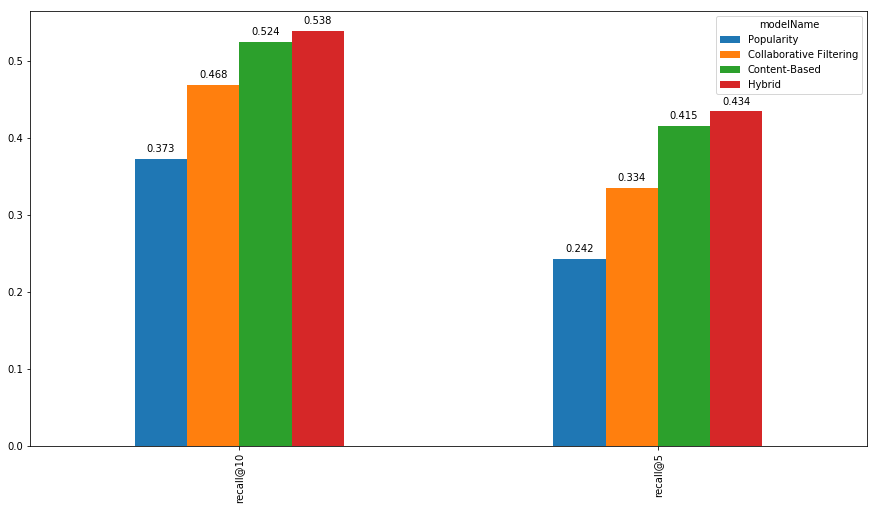

In [79]:
%matplotlib inline
ax = global_metrics_df.transpose().plot(kind='bar', figsize=(15,8))
for p in ax.patches:
    ax.annotate("%.3f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')

### Conclusion
#### In this project, we've explored and compared the main Recommender Systems techniques on CI&T Deskdrop dataset. It could be observed that for articles recommendation, content-based filtering and a hybrid method performed better than Collaborative Filtering alone.

#### Results can be improved by doing following
 - **We can leverage time attribute in articles to recommend articles available in particular time frame**
 - **We can leverage additional features like users location, device etc to model user's preferences and factor that in while making recommendations**
 - **We can try using deep learning models like sequential model and see if that outperforms hybrid model for making recommendations**